Notebook original diseñado por Daniel Moser (UT Southwestern Medical Center). El contenido fue adaptado para propositos educativos en la UNI.

In [1]:
%matplotlib inline

In [ ]:
!pip install keras

# Hablemos un poco sobre la clasficación

#### Utilizaremos este artículo para explorar las métricas y evaluación de la clasificación
https://www.iartificial.net/precision-recall-f1-accuracy-en-clasificacion/

# Introducción a Keras y TensorFlow aplicados a la clasificación de imágenes



Utilizaremos regresiones logísitacas en Scikit-learn, redes neuronales tradicionales, y redes neuronales convolucionales para clasificar imágenes

## Objetivo

Nuestro objetivo es construir y entrenar una red neuronal en miles de imágenes de dígitos escritos a mano para que pueda identificar con éxito otras cuando se presenten. Los datos que se incorporarán son la base de datos del MNIST que contiene 60.000 imágenes para entrenamiento y 10.000 imágenes de prueba. Usaremos la API Keras Python con TensorFlow como backend. La regresión logística con Scikit-learn se usará como modeo base.

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

## Librarias requeridas para correr algoritmos

Primero, requerimos cargar algunas librerías para correr los algoritmos

In [2]:
import numpy as np                   # Librería para manipulación de datos y otras operaciones matemáticas
import matplotlib.pyplot as plt      # Librería para graficar
import seaborn as sns                # Otra Librería para graficar
import random                        # Librería para gener números semi-aleatoros

from keras.datasets import mnist     # Cargar dataset de MNIST de Keras
from keras.models import Sequential  # Modelo a utilizar

from keras.layers.core import Dense, Dropout, Activation # Algunas capas que le agregaremos a la red neuronal
from keras.utils import np_utils                         # Herramientas adicionales relacionadas a Numpy

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

## Carguemos datos de entrenamiento

Analizaremos el contenido de los datos

In [3]:
# Los datos de MNIST están divididos en 60,000 imágenes de 28 x 28 pixeles y 10,000 imágenes de validación con el mismo pixelado
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, podemos gráficar algunas imágenes.

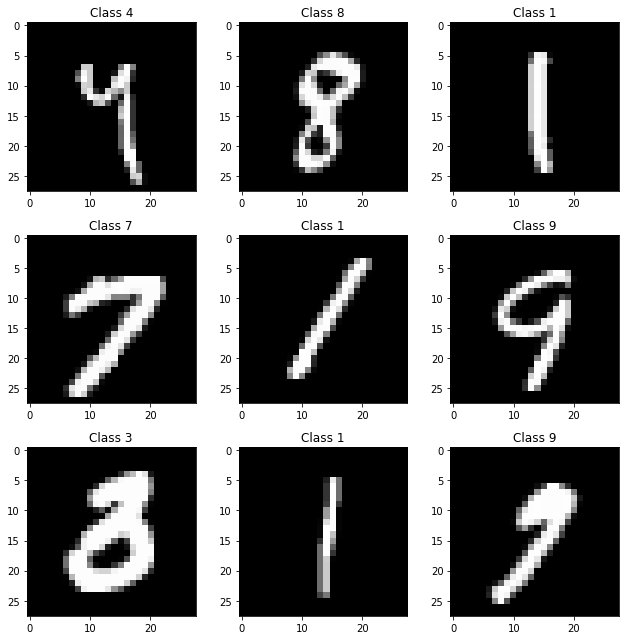

In [4]:
plt.rcParams['figure.figsize'] = (9,9) # Incrementemos un poco más el tamaño de las imágenes

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

Examinemos un solo dígito un poco más de cerca e imprimamos la matriz que representa el último dígito.

In [5]:
# Una pequeña función para mostrar una matriz ordenada
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# A imprimir!        
matprint(X_train[num])

0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  
0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  
0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  
0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  
0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  
0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  
0  0  0  0  0  0   0    0    0    0    0    0    0    0   14   74  254  254  140   46    0   0  0  0  0  0  0  0  
0  0  0  0  0  0   0    0    0    0    0    0    0    8  149  253  253  253  253  245  123   0  0  0  0  0  0  0  
0  0  0  0  0  0   0    0    0    0    0    0   13  183  254  253  253  253  253


Cada pixel representa un número de entero de 8 bits. El valor del pixel oscila entre 0 y 255  (0=blanco, 255=negro, 127.5=??). A esto le llamamos un pixel de un solo canal. En imágenes de colores cada pixel tiene tres valores que oscilan entre 0 y 255. Estos valores representan la intensidad del rojo, verde y azul respectivamente.

## Formatear la capa de datos de entrada

En lugar de una matriz de 28 x 28, construimos nuestra red para aceptar un vector de longitud 784.

A continuación, es necesario remodelar (o aplanar) cada imagen en un vector. También normalizaremos las entradas para que estén en el rango [0-1] en lugar de [0-255]. Generalmente se recomienda normalizar las entradas, de modo que cualquier dimensión adicional (para otras arquitecturas de red) sea de la misma escala.

<img src='https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/flatten.png?raw=1' >

In [6]:
X_train = X_train.reshape(60000, 784) # reajustar tamaño de las 60,000 28 x 28 matrices en 60,000 vectores de 784 de longitud.
X_test = X_test.reshape(10000, 784)   # reajustar tamaño de las 10,000 28 x 28 matrices en 10,000 vectores de 784 de longitud.

X_train = X_train.astype('float32')   # Cambiar enteros a decimales, o "float"
X_test = X_test.astype('float32')

X_train /= 255                        # normalizar cada valor de cada píxel para todo el vector de cada entrada
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


#### Primero intentemos con una regresión logistica común y corriente

In [7]:
# # Ajustemos la variable objetivo para el modelo de regresión logística - requiere un formato 1D
# Y_train_logit = np.argmax(y_train, axis=1)
# Y_test_logit = np.argmax(y_test, axis=1)

# Entrenemos modelo de regresión logística
logit = LogisticRegression(random_state=42, solver='liblinear')
logit.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
# Función para mostrar resultados de clasificación
def plotMetrics(matriz, reporte):
  
  # Iniciemos el canvas
  fig, ax = plt.subplots(figsize=(8,8))

  # Creemos el heatmap y asignemosle un título
  sns.heatmap(matriz, cmap="RdBu", annot=True, cbar=False, fmt=",d",linewidths=.5, ax=ax)
  ax.set_title("Matriz de confusion")
  plt.show()

  # Mostremos el reporte de clasificación
  print(reporte)

Resultados de entrenamiento


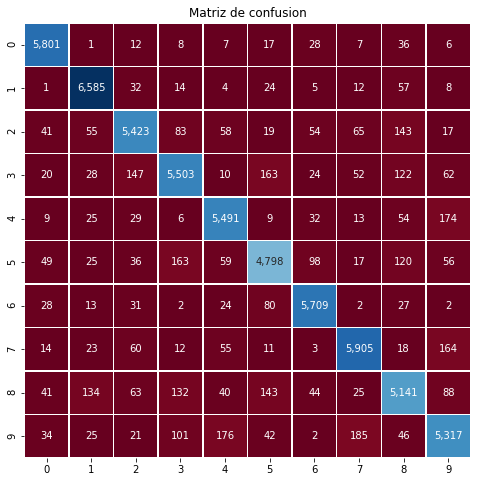

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5923
           1       0.95      0.98      0.96      6742
           2       0.93      0.91      0.92      5958
           3       0.91      0.90      0.91      6131
           4       0.93      0.94      0.93      5842
           5       0.90      0.89      0.89      5421
           6       0.95      0.96      0.96      5918
           7       0.94      0.94      0.94      6265
           8       0.89      0.88      0.89      5851
           9       0.90      0.89      0.90      5949

    accuracy                           0.93     60000
   macro avg       0.93      0.93      0.93     60000
weighted avg       0.93      0.93      0.93     60000



Resultados de validación


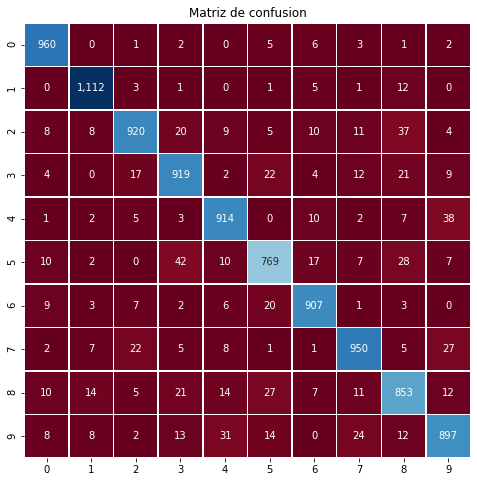

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.89      0.91      1032
           3       0.89      0.91      0.90      1010
           4       0.92      0.93      0.93       982
           5       0.89      0.86      0.88       892
           6       0.94      0.95      0.94       958
           7       0.93      0.92      0.93      1028
           8       0.87      0.88      0.87       974
           9       0.90      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [9]:
# Calculemos predicciones
y_pred_train = logit.predict(X_train)
y_pred_test = logit.predict(X_test)


# Mostremos resultados de entrenamiento
matriz_train = confusion_matrix(y_train, y_pred_train)
reporte_train = classification_report(y_train, y_pred_train) 
print("Resultados de entrenamiento")
plotMetrics(matriz_train, reporte_train)

# Hacer espacio
print("\n")


# Mostremos resultados de validación
matriz_test = confusion_matrix(y_test, y_pred_test)
reporte_test = classification_report(y_test, y_pred_test) 
print("Resultados de validación")
plotMetrics(matriz_test, reporte_test)

Modificamos las clases (el dígito en cuestión) en formato "one-hot", i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

Si el resultado final de nuestra red está muy cerca de una de estas clases, lo más probable es que sea esa clase. Por ejemplo, si el resultado final es:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
entonces lo más probable es que la imagen sea la del dígito `1`.

In [10]:
nb_classes = 10 # Número de dígitos únicos. es decir, hay 10 dígitos entre el 0 y el 9

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# Building a 3-layer fully connected network (FCN)

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/figure.png?raw=1" />

In [11]:
# El modelo secuencial es una pila lineal de capas y es muy común.

model = Sequential()

## La primera capa de la red

In [12]:
# La primera capa oculta es un conjunto de 512 nodos (neuronas artificiales).
# Cada nodo recibirá un elemento de cada vector de entrada y le aplicará algo de peso y sesgo (coeficiente, i.e. y = mX + B).

model.add(Dense(512, input_shape=(784,))) #(784,) no es un error -- esto representa un vector de longitud 784

In [13]:
# Una "activación" es una función no lineal que se aplica a la salida de la capa de arriba.
# Comprueba el nuevo valor del nodo y decide si esa neurona artificial se ha disparado.
# La unidad lineal rectificada (ReLU) convierte todas las entradas negativas en nodos en la siguiente capa a cero.
# Entonces, esas entradas no se consideran disparadas.
# Los valores positivos de un nodo no se modifican.

model.add(Activation('relu'))

$$f(x) = max (0,x)$$
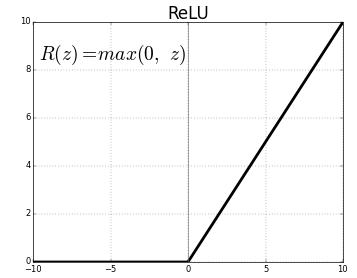

In [14]:
# El abandono pone a cero una selección de salidas aleatorias (es decir, desactiva su activación)
# La deserción ayuda a proteger el modelo de memorizar o "overfit" los datos de entrenamiento.
model.add(Dropout(0.2))

## Agreguemos la segunda capa de a red

In [15]:
# La segunda capa oculta parece idéntica a nuestra primera capa.
# Sin embargo, en lugar de que cada uno de los 512 nodos reciba 784 entradas de los datos de imagen de entrada,
# reciben 512 entradas de la salida de la primera capa de 512 nodos.

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

## Agregemos la capa de output de la red

In [16]:
# La capa final de 10 neuronas está completamente conectada a la capa anterior de 512 nodos.
# La capa final de un FCN debe ser igual al número de clases deseadas (10 en este caso).
model.add(Dense(10))

In [17]:
# La activación "softmax" representa una distribución de probabilidad sobre K diferentes resultados posibles.
# Sus valores son todos no negativos y suman 1.

model.add(Activation('softmax'))

In [18]:
# Resumen del modelo construido

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5

## Compilar el modelo

Keras se basa en Theano y TensorFlow. Ambos paquetes le permiten definir un * gráfico de cálculo * en Python, que luego se compila y se ejecuta de manera eficiente en la CPU o GPU sin la sobrecarga del intérprete de Python.

Al compilar un modelo, Keras le pide que especifique su **función de pérdida** y su **optimizador**. La función de pérdida que usaremos aquí se llama *entropía cruzada categórica*, y es una función de pérdida muy adecuada para comparar dos distribuciones de probabilidad.

Nuestras predicciones son distribuciones de probabilidad en diez dígitos diferentes (p. Ej., "Estamos 80% seguros de que esta imagen es un 3, 10% seguro que es un 8, 5% es un 2, etc.") y el objetivo es una distribución de probabilidad con 100% para la categoría correcta y 0 para todo lo demás. La entropía cruzada es una medida de cuán diferente es su distribución predicha de la distribución objetivo. 

El optimizador ayuda a determinar qué tan rápido aprende el modelo a través del **descenso de gradiente**. La velocidad a la que desciende un gradiente se denomina **velocidad de aprendizaje**.

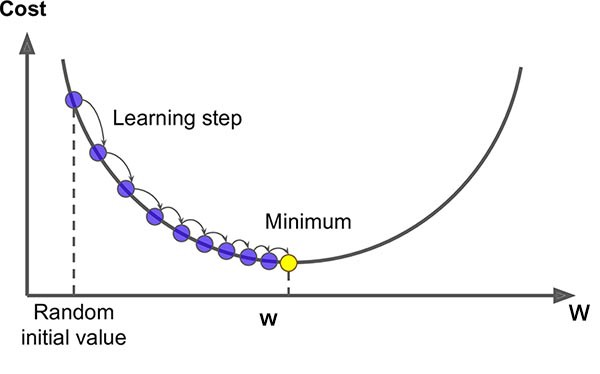

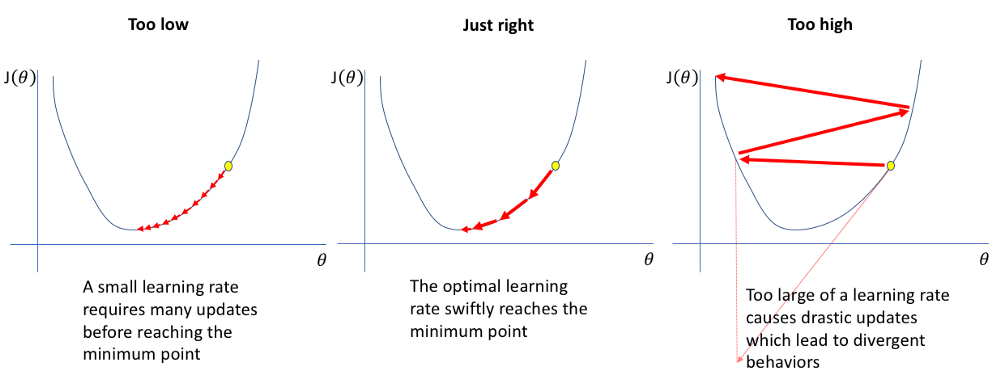

Entonces, ¿son mejores las tasas de aprendizaje más pequeñas? ¡No exactamente! Es importante que un optimizador no se quede atascado en los mínimos locales mientras descuida el mínimo global de la función de pérdida. A veces, eso significa intentar una tasa de aprendizaje mayor para superar un mínimo local.

In [19]:
# Utilicemos el Optimizador ADAM para este problema
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Entrenemos el modelo!

In [20]:
# Función para graficar los resultados de entrenamiento de redes neuronales

def plotTraining():

  # Obtengamos los datos de entrenamiento y como fluctua el accuracy en cada vuelta (epoch)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  # Lo mismo para el costo
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Contemos el numero de epochs (vueltas) para usarlas en el eje X
  epochs = range(1, len(acc) + 1)

  # Grafiquemos
  plt.plot(epochs, acc, 'bo', label='Accuracy en entrenamiento')
  plt.plot(epochs, val_acc, 'b', label='Accuracy en validación')
  plt.title('Accuracy en validación y entrenamiento')
  plt.legend()

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Costo en entrenamiento')
  plt.plot(epochs, val_loss, 'b', label='Costo en validación')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

El tamaño del lote (o batch) determina la cantidad de datos por paso que se utilizan para calcular la función de pérdida, los gradientes y la propagación hacia atrás. Los lotes grandes permiten que la red complete su entrenamiento más rápido; sin embargo, hay otros factores a considerar más allá de la velocidad de entrenamiento.

Un tamaño de lote demasiado grande suaviza los mínimos locales de la función de pérdida, lo que hace que el optimizador se establezca en uno porque cree que encontró el mínimo global.

Un tamaño de lote demasiado pequeño crea una función de pérdida muy ruidosa y es posible que el optimizador nunca encuentre el mínimo global.

¡Así que un buen tamaño de lote puede requerir un poco de prueba y error para encontrarlo!

In [21]:
history = model.fit(X_train, Y_train,batch_size=128, epochs=5, verbose=1, validation_data=(X_test, Y_test))

Epoch 1/5
469/469 [==============================] - 8s 16ms/step - loss: 0.2518 - accuracy: 0.9240 - val_loss: 0.1012 - val_accuracy: 0.9678
Epoch 2/5
469/469 [==============================] - 8s 16ms/step - loss: 0.1009 - accuracy: 0.9690 - val_loss: 0.0798 - val_accuracy: 0.9747
Epoch 3/5
469/469 [==============================] - 8s 16ms/step - loss: 0.0708 - accuracy: 0.9780 - val_loss: 0.0689 - val_accuracy: 0.9792
Epoch 4/5
469/469 [==============================] - 7s 16ms/step - loss: 0.0541 - accuracy: 0.9829 - val_loss: 0.0701 - val_accuracy: 0.9787
Epoch 5/5
469/469 [==============================] - 8s 17ms/step - loss: 0.0459 - accuracy: 0.9847 - val_loss: 0.0715 - val_accuracy: 0.9802


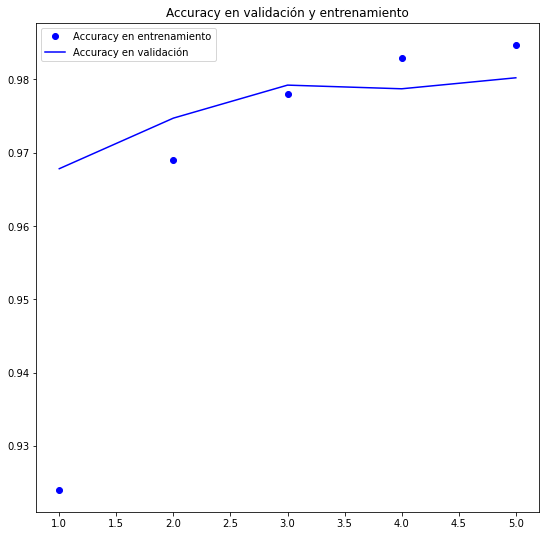

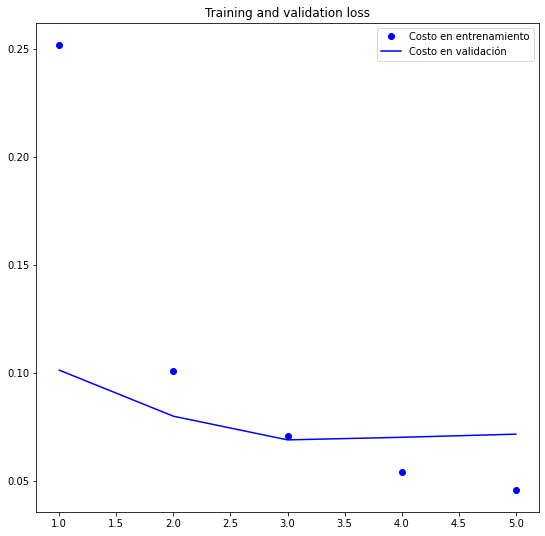

In [22]:
# Veamos el resultado de entrenamiento
plotTraining()

Los dos números, en orden, representan el valor de la función de pérdida de la red en el conjunto de entrenamiento y la precisión general de la red en los datos de entrenamiento. Pero, ¿cómo funciona con datos sobre los que no se entrenó?

## Evaluemos el "accuracy" del modelo en los datos de evaluacion

Resultados de entrenamiento


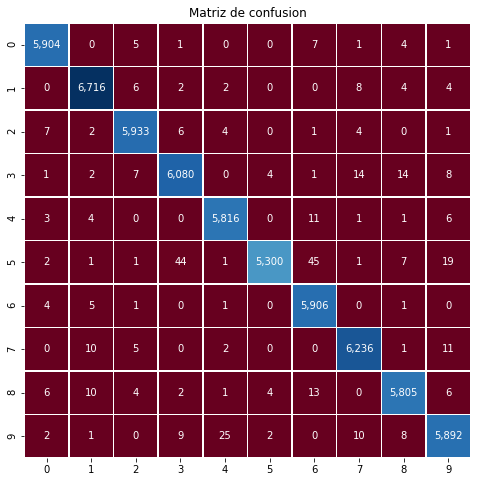

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5923
           1       0.99      1.00      1.00      6742
           2       1.00      1.00      1.00      5958
           3       0.99      0.99      0.99      6131
           4       0.99      1.00      0.99      5842
           5       1.00      0.98      0.99      5421
           6       0.99      1.00      0.99      5918
           7       0.99      1.00      0.99      6265
           8       0.99      0.99      0.99      5851
           9       0.99      0.99      0.99      5949

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000



Resultados de validación


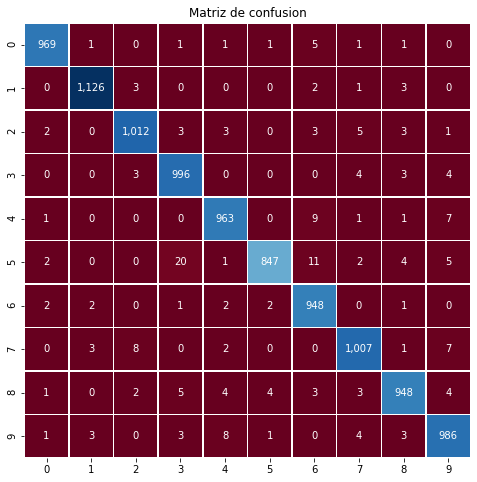

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.95      0.97       892
           6       0.97      0.99      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [24]:
# Calculemos predicciones
Y_pred_train = np.argmax(model.predict(X_train), axis=1)
Y_pred_test = np.argmax(model.predict(X_test), axis=1)


# Mostremos resultados de entrenamiento
matriz_train = confusion_matrix(y_train, Y_pred_train)
reporte_train = classification_report(y_train, Y_pred_train) 
print("Resultados de entrenamiento")
plotMetrics(matriz_train, reporte_train)

# Hacer espacio
print("\n")


# Mostremos resultados de validación
matriz_test = confusion_matrix(y_test, Y_pred_test)
reporte_test = classification_report(y_test, Y_pred_test) 
print("Resultados de validación")
plotMetrics(matriz_test, reporte_test)

### Inspeccionemos el output

Siempre es una buena idea inspeccionar la salida y asegurarse de que todo parezca sano. Aquí veremos algunos ejemplos de lo que hace bien y algunos ejemplos de lo que hace mal.

In [25]:
# La función predict_classes genera la clase de probabilidad más alta
# según el clasificador entrenado para cada ejemplo de entrada.
predicted_classes = model.predict_classes(X_test)

# Verifique qué elementos obtuvimos bien / mal
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


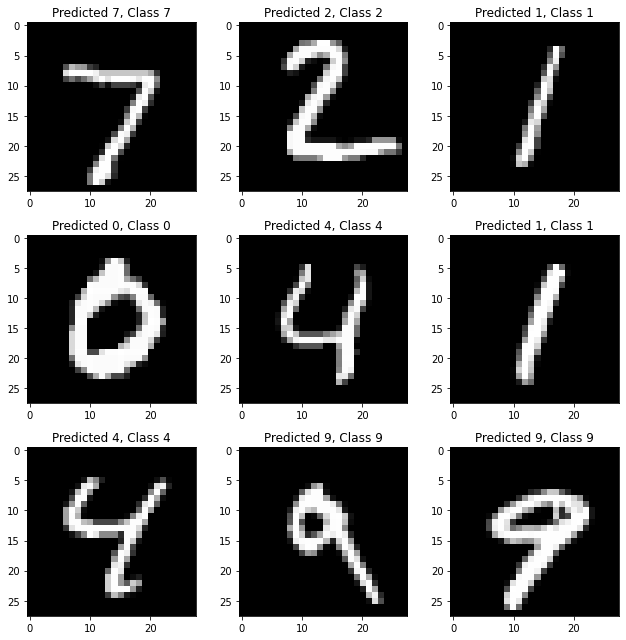

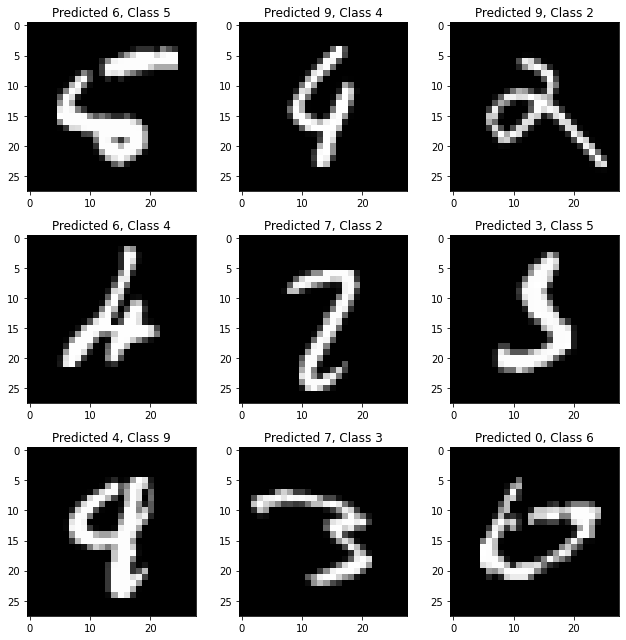

In [26]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.tight_layout()
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    
plt.tight_layout()

# ¡Intentando experimentar con el tamaño del lote!

#### ¿Cómo afecta el aumento del tamaño del lote a 10,000 el tiempo de entrenamiento y la precisión de la prueba?

#### ¿Qué tal un tamaño de lote de 32?

# ¡Presentamos la convolución! ¿Qué es?

Antes, construimos una red que acepta los valores de píxeles normalizados de cada valor y opera únicamente con esos valores. ¿Qué pasaría si pudiéramos alimentar diferentes características (por ejemplo, curvatura, bordes) de cada imagen en una red y hacer que la red aprenda qué características son importantes para clasificar una imagen?

¡Esto es posible a través de la convolución! La convolución aplica kernels (filtros) que atraviesan cada imagen y generan mapas de características.

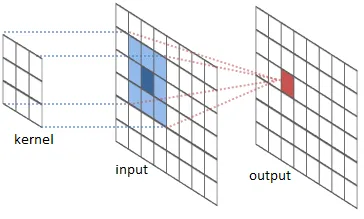

En el ejemplo anterior, la imagen es una matriz de 5 x 5 y el núcleo que la recorre es una matriz de 3 x 3. Se lleva a cabo una operación de producto escalar entre la imagen y el núcleo y se genera la característica convolucionada. Cada núcleo de una CNN aprende una característica diferente de una imagen.

Los kernels se utilizan a menudo en software de fotoedición para aplicar desenfoque, detección de bordes, nitidez, etc.

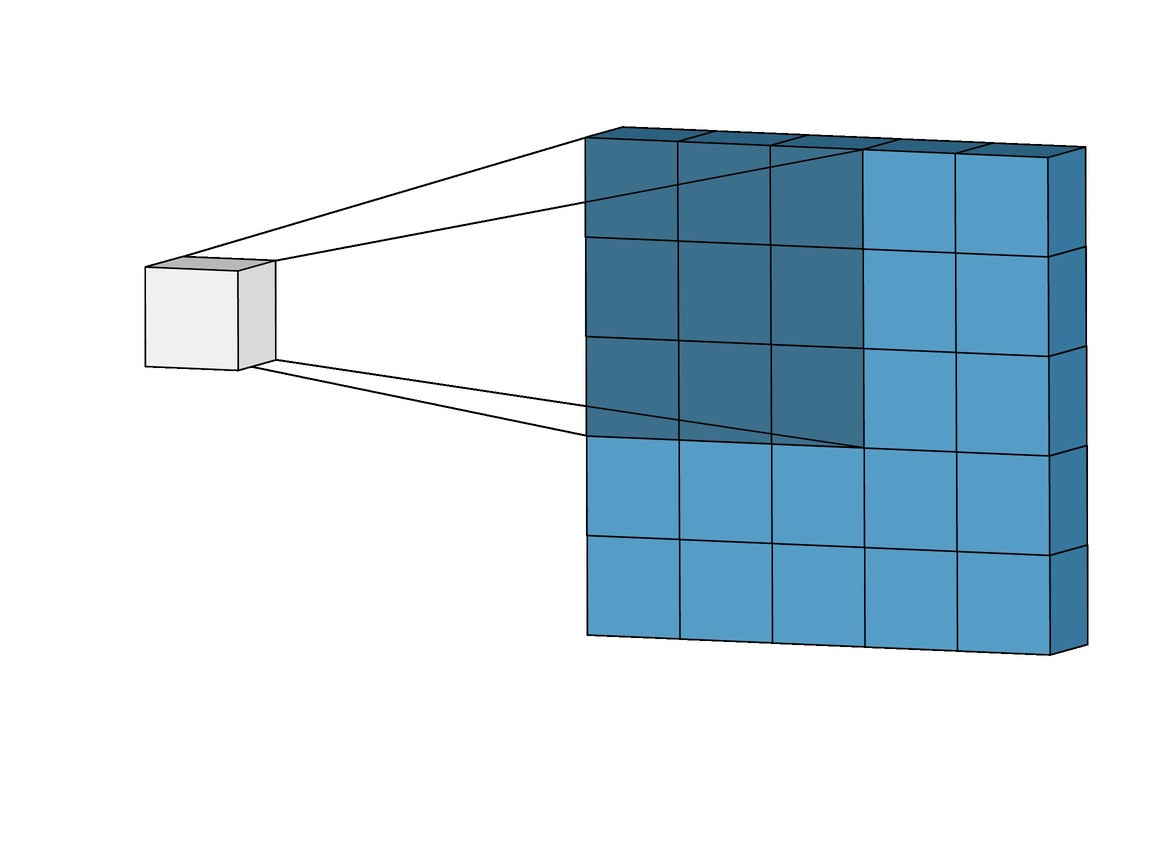

Los núcleos en las redes de aprendizaje profundo se utilizan de manera similar, es decir, destacando alguna característica. Combinado con un sistema llamado **agrupación máxima**, los elementos no resaltados se descartan de cada mapa de características, dejando solo las características de interés, reduciendo la cantidad de parámetros aprendidos y disminuyendo el costo computacional (por ejemplo, memoria del sistema).

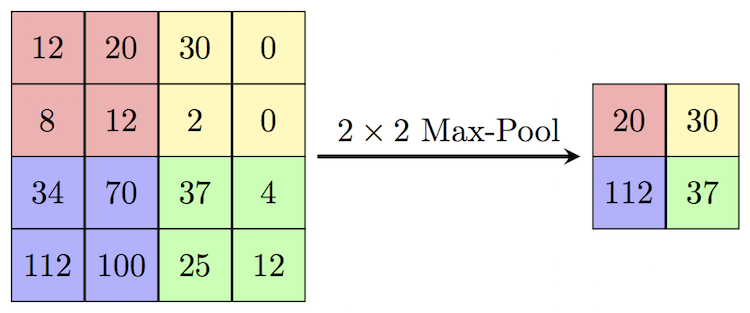

## Construyamos una Red Neuronal Convolucional profunda

In [27]:
# importemos algunas herramientas adicionales

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers.normalization import BatchNormalization

In [28]:
# Carguemos los datos nuevament
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [29]:
# Nuevamente, formatea
# Excepto que no aplanamos cada imagen en un vector de longitud 784 porque queremos realizar primero convoluciones

X_train = X_train.reshape(60000, 28, 28, 1) # añadir una dimensión adicional para representar el canal único
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # cambiemos enteros a decimales (floats) de 32-bits
X_test = X_test.astype('float32')

X_train /= 255                              # normalizar cada valor de cada píxel para todo el vector de cada entrada
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [30]:
# codificación "one-hot"

nb_classes = 10 # number de dígitos

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [31]:
model = Sequential()                                 # Apilado lineal de capas

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) # 32 kernels 3x3 diferentes, por lo que 32 mapas de características
model.add(BatchNormalization(axis=-1))               # normalizar cada mapa de características antes de la activación
convLayer01 = Activation('relu')                     # activactión
model.add(convLayer01)

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))                        # 32 kernels 3x3 diferentes, por lo que 32 mapas de características
model.add(BatchNormalization(axis=-1))               # normalizar cada mapa de características antes de la activación
model.add(Activation('relu'))                        # activación
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Agrupa los valores máximos en un kernel 2x2
model.add(convLayer02)

# Convolution Layer 3
model.add(Conv2D(64,(3, 3)))                         # 64 kernels 3x3 diferentes: 64 mapas de características
model.add(BatchNormalization(axis=-1))               # normalizar cada mapa de características antes de la activación
convLayer03 = Activation('relu')                     # activación
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 kernels 3x3 diferentes: 64 mapas de características
model.add(BatchNormalization(axis=-1))               # normalizar cada mapa de características antes de la activación
model.add(Activation('relu'))                        # activación
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Agrupa los valores máximos en un kernel 2x2
model.add(convLayer04)
model.add(Flatten())                                 # Aplanar la matriz de salida final de 4x4x64 en un vector de 1024 de longitud

# Fully Connected Layer 5
model.add(Dense(512))                                # 512 nodos completamente conectados
model.add(BatchNormalization())                      # normalización
model.add(Activation('relu'))                        # activación

# Fully Connected Layer 6                       
model.add(Dropout(0.2))                              # 20% dropout de nodos seleccionados al azar
model.add(Dense(10))                                 # ültimos 10 nodos completamente conectados
model.add(Activation('softmax'))                     # Activación softmax

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)       

In [33]:
# Usaremos el mismo optimizador, ADAM

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
# el aumento de datos evita el sobreajuste al cambiar ligeramente los datos al azar
# Keras tiene una función incorporada para realizar un aumento automático

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [35]:
# Luego podemos alimentar nuestros datos aumentados en lotes
# Además de las consideraciones de función de pérdida como antes, este método en realidad resulta en ahorros de memoria significativos
# porque en realidad estamos CARGANDO los datos en la red en lotes antes de procesar cada lote

# Antes, todos los datos se cargaban en la memoria, pero luego se procesaban en lotes.

train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [36]:
# Ahora podemos entrenar nuestro modelo que es alimentado con datos por nuestro cargador por lotes
# Los pasos por época siempre deben ser el tamaño total del conjunto dividido por el tamaño del lote

# AHORRO DE MEMORIA SIGNIFICATIVO (importante para redes más grandes y profundas)

history = model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1, 
                    validation_data=test_generator, validation_steps=10000//128)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
468/468 [==============================] - 174s 371ms/step - loss: 0.1340 - accuracy: 0.9591 - val_loss: 0.0709 - val_accuracy: 0.9799
Epoch 2/5
468/468 [==============================] - 174s 371ms/step - loss: 0.0496 - accuracy: 0.9847 - val_loss: 0.0246 - val_accuracy: 0.9921
Epoch 3/5
468/468 [==============================] - 174s 371ms/step - loss: 0.0397 - accuracy: 0.9876 - val_loss: 0.0500 - val_accuracy: 0.9841
Epoch 4/5
468/468 [==============================] - 174s 371ms/step - loss: 0.0342 - accuracy: 0.9890 - val_loss: 0.0233 - val_accuracy: 0.9924
Epoch 5/5
468/468 [==============================] - 174s 371ms/step - loss: 0.0291 - accuracy: 0.9910 - val_loss: 0.0209 - val_accuracy: 0.9934


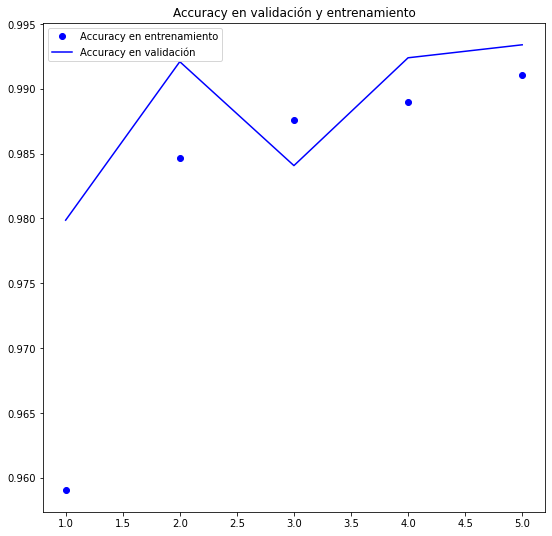

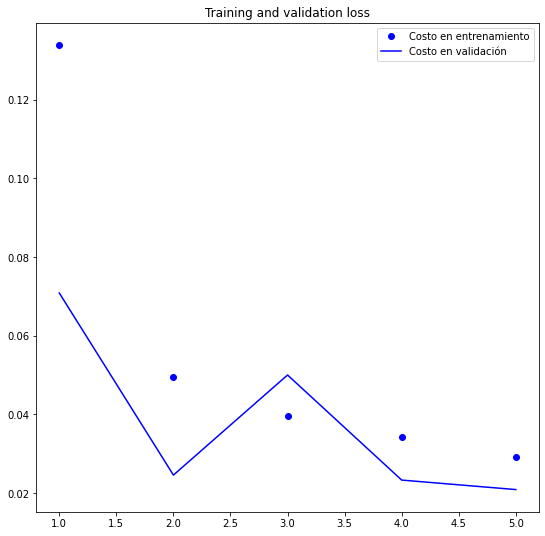

In [37]:
# Grafiquemos resultados de entrenamiento
plotTraining()

Resultados de entrenamiento


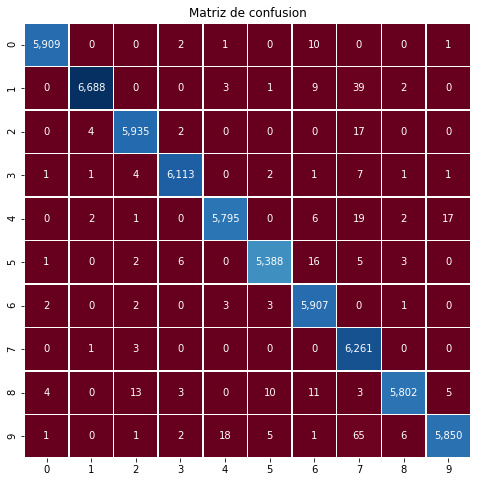

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5923
           1       1.00      0.99      1.00      6742
           2       1.00      1.00      1.00      5958
           3       1.00      1.00      1.00      6131
           4       1.00      0.99      0.99      5842
           5       1.00      0.99      1.00      5421
           6       0.99      1.00      0.99      5918
           7       0.98      1.00      0.99      6265
           8       1.00      0.99      0.99      5851
           9       1.00      0.98      0.99      5949

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000



Resultados de validación


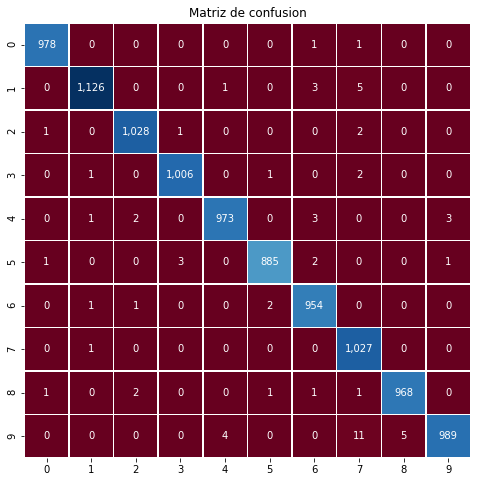

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      0.99      0.99      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       0.99      1.00      0.99       958
           7       0.98      1.00      0.99      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [38]:
# Calculemos predicciones
Y_pred_train = np.argmax(model.predict(X_train), axis=1)
Y_pred_test = np.argmax(model.predict(X_test), axis=1)


# Mostremos resultados de entrenamiento
matriz_train = confusion_matrix(y_train, Y_pred_train)
reporte_train = classification_report(y_train, Y_pred_train) 
print("Resultados de entrenamiento")
plotMetrics(matriz_train, reporte_train)

# Hacer espacio
print("\n")


# Mostremos resultados de validación
matriz_test = confusion_matrix(y_test, Y_pred_test)
reporte_test = classification_report(y_test, Y_pred_test) 
print("Resultados de validación")
plotMetrics(matriz_test, reporte_test)

## excelentes resultados! 

Pero, como se ven las capas intermedias?

https://linux-blog.anracom.com/2020/06/28/a-simple-cnn-for-the-mnist-dataset-iv-visualizing-the-output-of-convolutional-layers-and-maps/